<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup-the-circuit-ansatz" data-toc-modified-id="Setup-the-circuit-ansatz-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup the circuit ansatz</a></span><ul class="toc-item"><li><span><a href="#Create-a-qiskit-circuit" data-toc-modified-id="Create-a-qiskit-circuit-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Create a qiskit circuit</a></span></li><li><span><a href="#Create-IsoMPS-Object-from-list-of-parameterized-circuits" data-toc-modified-id="Create-IsoMPS-Object-from-list-of-parameterized-circuits-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Create IsoMPS Object from list of parameterized circuits</a></span></li></ul></li><li><span><a href="#Simulation" data-toc-modified-id="Simulation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulation</a></span><ul class="toc-item"><li><span><a href="#Define-a-Noise-model-in-qiskit" data-toc-modified-id="Define-a-Noise-model-in-qiskit-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Define a Noise model in qiskit</a></span></li><li><span><a href="#Specify-Measurement" data-toc-modified-id="Specify-Measurement-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Specify Measurement</a></span></li><li><span><a href="#Run-Qiskit-simulation" data-toc-modified-id="Run-Qiskit-simulation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Run Qiskit simulation</a></span></li></ul></li></ul></div>

In [1]:
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")

# standard imports
import numpy as np
from scipy.optimize import minimize
import scipy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit, IsoTensor
import circuits.basic_circuits as circuits
import mps.mps as mps

# Setup the circuit ansatz
## Create a qiskit circuit
(using a function from circuits.basic_circuits)

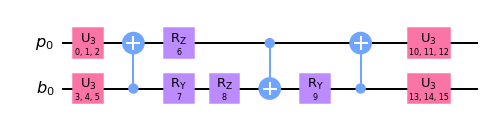

In [2]:
# Create a circuit
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(1,'b') # bond qubits
circ = qk.QuantumCircuit(preg,breg) # circuit

# make a u4 circuit in qiskit
num_params = 16
params = [qk.circuit.Parameter(str(j)) for j in range(num_params)] 
circuits.add_u4_circ(circ,preg[0],breg[0],params)
circ.draw(output='mpl',scale=1.0) # draw circuit 

## Create IsoMPS Object from list of parameterized circuits
steps:
1) wrap the circuit(s) and parameters into QKParamCircuit objects

2) make a list of QKParamCircuit's of len = length of unit cell = l_uc for MPS (here l_uc=1)

3) create psi of length L, which just repeats the unit cell structure L times (L can be infinity for classical simulations, obviously has to be finite for qiskit simulations)


In [13]:
# create length-10 IsoMPS object from circuit
L=5
# create list of parameterized circuit objects 
# (just qiskit circuits wrapped w/ their parameters)
#from which to create qMPS
pcircs = [QKParamCircuit(circ, params)]
psi = IsoMPS(preg,
             breg,
             pcircs,
             L=L)


# example ways to get tensors and unitaries from psi
param_dict = dict(zip(psi.param_list,np.random.randn(len(psi.param_list)))) # choose some random parameter values
tensors = psi.tensors(param_dict) # list of tensors for each site, index order: physical, bond-out, bond-in
unitaries = psi.unitaries(param_dict) # list of unitaries, index order: p-out, b-out, p-in, b-in
psi_tenpy = psi.to_tenpy(param_dict,L=L) # convert to tenpy MPS

# Simulation
## Define a Noise model in qiskit
(see qiskit docs for other options, we've just been using the simplest option of depolarizing noise with different one qubit (1q) and two qubit (2q) error rates)

In [4]:
## Define Noise Model ##
# errors (simulation)
perr_1q = 0.0005 # 1-qubit gate error
perr_2q = 0.005 # 2-qubit gate error
# depolarizaing errors
depol_1q = noise.depolarizing_error(perr_1q, 1)
depol_2q = noise.depolarizing_error(perr_2q, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_1q, ['u1', 'u2', 'u3','rx','ry','rz'])
noise_model.add_all_qubit_quantum_error(depol_2q, ['cx','cz','rxx'])


## Specify Measurement
Measurements are specified by list of strings with the following structure
For MPS with 1-site unit cell ['x','z','x',...] would measure first qubit in x-basis, second in z and so on
For MPS with 2-site unit cell ['xz',xx',...] would measure 1st qubit in 1st unit cell in x, 2nd qubit in 1st unit cell in z, etc...

Right now, one needs to re-create the psi-object for each different measurement string 
("set_basis" method is on to-do list...)

In [14]:
measurement_string = ['x']*L
psi = IsoMPS(preg,
             breg,
             pcircs,
             L=L,
             bases=measurement_string)

## Run Qiskit simulation

In [16]:
simulator = qk.Aer.get_backend('qasm_simulator')
job = qk.execute(psi.construct_circuit(param_dict), 
                simulator, 
                shots=1000,
                noise_model=noise_model)
result = job.result()

# prints dict of {measurement-outcome: number of times that outcome appeared}
print(result.get_counts()) 

{'00000': 10, '00001': 12, '10000': 7, '10001': 17, '10010': 7, '10011': 36, '10100': 19, '10101': 37, '10110': 13, '10111': 37, '11000': 14, '11001': 8, '11010': 16, '11011': 75, '11100': 25, '11101': 81, '11110': 10, '11111': 224, '00010': 12, '00011': 28, '00100': 8, '00101': 15, '00110': 2, '00111': 12, '01000': 19, '01001': 6, '01010': 15, '01011': 66, '01100': 17, '01101': 41, '01110': 10, '01111': 101}
